# Data Space Report


<img src="images/polito_logo.png" alt="Polito Logo" style="width: 200px;"/>


## Pittsburgh Bridges Data Set

<img src="images/andy_warhol_bridge.jpg" alt="Andy Warhol Bridge" style="width: 200px;"/>

    Andy Warhol Bridge - Pittsburgh.

Report created by Student Francesco Maria Chiarlo s253666, for A.A 2019/2020.

**Abstract**:The aim of this report is to evaluate the effectiveness of distinct, different statistical learning approaches, in particular focusing on their characteristics as well as on their advantages and backwards when applied onto a relatively small dataset as the one employed within this report, that is Pittsburgh Bridgesdataset.

**Key words**:Statistical Learning, Machine Learning, Bridge Design.

### Imports Section <a class="anchor" id="imports-section"></a>

In [1]:
# =========================================================================== #
# STANDARD IMPORTS
# =========================================================================== #
print(__doc__)

# Critical Imports
# --------------------------------------------------------------------------- #
import warnings; warnings.filterwarnings("ignore")

# Imports through 'from' syntax
# --------------------------------------------------------------------------- #
from pprint import pprint
from itertools import islice
from os import listdir; from os.path import isfile, join
# Standard Imports
# --------------------------------------------------------------------------- #
import copy; import os
import sys; import time
import itertools
import sklearn

# Imports through 'as' syntax
# --------------------------------------------------------------------------- #
import numpy as np; import pandas as pd

# Imports for handling graphics
# --------------------------------------------------------------------------- #
%matplotlib inline
# Matplotlib pyplot provides plotting API
import matplotlib as mpl
from matplotlib import pyplot as plt
import chart_studio.plotly.plotly as py
import seaborn as sns;  sns.set(style="ticks", color_codes=True) # sns.set()

Automatically created module for IPython interactive environment


In [2]:
# =========================================================================== #
# UTILS IMPORTS (Done by myself)
# =========================================================================== #
from utils.load_dataset_pittsburg_utils import load_brdiges_dataset; from utils.display_utils import *
from utils.preprocessing_utils import *; from utils.training_utils import *
from utils.sklearn_functions_custom import *; from utils.learning_curves_custom import *
from utils.training_utils_v2 import fit_by_n_components, fit_all_by_n_components, grid_search_all_by_n_components

In [3]:
# =========================================================================== #
# sklearn IMPORT
# =========================================================================== #
from sklearn.decomposition import PCA, KernelPCA

# Import scikit-learn classes: models (Estimators).
from sklearn.naive_bayes import GaussianNB, MultinomialNB   # Non-parametric Generative Model
from sklearn.linear_model import LogisticRegression         # Parametric Linear Discriminative Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC                          # Parametric Linear Discriminative "Support Vector Classifier"
from sklearn.tree import DecisionTreeClassifier      # Non-parametric Model
from sklearn.ensemble import RandomForestClassifier  # Non-parametric Model (Meta-Estimator, that is, an Ensemble Method)

In [4]:
# =========================================================================== #
# READ INPUT DATASET
# =========================================================================== #

dataset_path = 'C:\\Users\\Francesco\Documents\\datasets\\pittsburgh_dataset'
dataset_name = 'bridges.data.csv'

TARGET_COL = 'T-OR-D'  # Target variable name
dataset, feature_vs_values = load_brdiges_dataset(dataset_path, dataset_name)

In [5]:
columns_2_avoid = ['ERECTED', 'LENGTH', 'LOCATION']

In [6]:
# Make distinction between Target Variable and Predictors
# --------------------------------------------------------------------------- #
columns = dataset.columns  # List of all attribute names

# Get Target values and map to 0s and 1s
y = np.array(list(map(lambda x: -1 if x == 1 else 1, dataset[TARGET_COL].values))) # y = np.array(list(map(lambda x: 0 if x == 1 else 1, dataset[TARGET_COL].values)))
print('Summary about Target Variable {target_col}'); print('-' * 50); print(dataset[TARGET_COL].value_counts())

# Get Predictors
X = dataset.loc[:, dataset.columns != TARGET_COL].values

Summary about Target Variable {target_col}
--------------------------------------------------
2    57
1    13
Name: T-OR-D, dtype: int64


In [7]:
# Standardizing the features
# --------------------------------------------------------------------------- #
scaler_methods = ['minmax', 'standard', 'norm']; scaler_method = 'standard'; rescaledX = preprocessing_data_rescaling(scaler_method, X)

shape features matrix X, after normalizing:  (70, 11)


## Pricipal Component Analysis

In [8]:
n_components = rescaledX.shape[1]; pca = PCA(n_components=n_components) # pca = PCA(n_components=2)
pca = pca.fit(rescaledX); X_pca = pca.transform(rescaledX) # X_pca = pca.fit_transform(X)

In [9]:
print(f"Cumulative varation explained(percentage) up to given number of pcs:")

tmp_data = []
principal_components = [pc for pc in '2,5,6,7,8,9,10'.split(',')]
for _, pc in enumerate(principal_components):
    n_components = int(pc); cum_var_exp_up_to_n_pcs = np.cumsum(pca.explained_variance_ratio_)[n_components-1]
    # print(f"Cumulative varation explained up to {n_components} pcs = {cum_var_exp_up_to_n_pcs}") # print(f"# pcs {n_components}: {cum_var_exp_up_to_n_pcs*100:.2f}%")
    tmp_data.append([n_components, cum_var_exp_up_to_n_pcs * 100])

tmp_df = pd.DataFrame(data=tmp_data, columns=['# PCS', 'Cumulative Varation Explained (percentage)']); tmp_df.head(len(tmp_data))

Cumulative varation explained(percentage) up to given number of pcs:


,# PCS,Cumulative Varation Explained (percentage)
0,2,47.738342
1,5,75.856460
2,6,82.615768
3,7,88.413903
4,8,92.661938
5,9,95.976841
6,10,98.432807


#### Major Pros & Cons of PCA

## Learning Models <a class="anchor" id="learning-models"></a>

In [10]:
# Parameters to be tested for Cross-Validation Approach

estimators_list = [GaussianNB(), LogisticRegression(random_state=0), KNeighborsClassifier(), SGDClassifier(random_state=0), SVC(random_state=0), DecisionTreeClassifier(random_state=0), RandomForestClassifier(random_state=0)]
estimators_names = ['GaussianNB', 'LogRegr', 'Knn', 'SGD', 'SVC', 'DecisionTree', 'RandomForest']
plots_names = list(map(lambda xi: f"{xi}_learning_curve.png", estimators_names))

pca_kernels_list = ['linear', 'poly', 'rbf', 'cosine', 'sigmoid']
cv_list = [10, 9, 8, 7, 6, 5, 4, 3, 2]

parmas_logistic_regression = {
    'penalty': ('l1', 'l2', 'elastic', None),
    'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
    'fit_intercept': (True, False),
    'tol': (1e-4, 1e-3, 1e-2),
    'class_weight': (None, 'balanced'),
    'C': (10.0, 1.0, .1, .01, .001, .0001),
    # 'random_state': (0,),
}


parmas_knn_forest = {
    'n_neighbors': (2,3,4,5,6,7,8,9,10),
    'weights': ('uniform', 'distance'),
    'metric': ('euclidean', 'minkowski', 'manhattan'),
    'leaf_size': (5, 10, 15, 30),
    'algorithm': ('ball_tree', 'kd_tree', 'brute'),
    # 'random_state': (0,),
}

parameters_sgd_classifier = {
    'loss': ('log', 'modified_huber'), # ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')
    'penalty': ('l2', 'l1', 'elasticnet'),
    'alpha': (1e-1, 1e-2, 1e-3, 1e-4),
    'max_iter': (50, 100, 150, 200, 500, 1000, 1500, 2000, 2500),
    'learning_rate': ('optimal',),
    'tol': (None, 1e-2, 1e-4, 1e-5, 1e-6)
    # 'random_state': (0,),
}

kernel_type = 'svm-rbf-kernel'
parameters_svm = {
    'gamma': (0.003, 0.03, 0.05, 0.5, 0.7, 1.0, 1.5),
    'max_iter':(1e+2, 1e+3, 2 * 1e+3, 5 * 1e+3, 1e+4, 1.5 * 1e+3),
    # 'penalty': ('l2','l1'),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid',],
    'C': (1e-4, 1e-3, 1e-2, 0.1, 1.0, 10, 1e+2, 1e+3),
    'probability': (True,), 
    # 'random_state': (0,),
}

parmas_decision_tree = {
    'splitter': ('random', 'best'),
    'criterion':('gini', 'entropy'),
    'max_features': (None, 'sqrt', 'log2'),
    'max_depth': (None, 3, 5, 7, 10,),
    'splitter': ('best', 'random',),
    'class_weight': (None, 'balanced'),
    'min_samples_leaf': (1,2,3,4,5),
    # 'random_state': (0,),
}

parmas_random_forest = {
    'n_estimators': (3, 5, 7, 10, 30, 50, 70, 100, 150, 200),
    'criterion':('gini', 'entropy'),
    'bootstrap': (True, False),
    'min_samples_leaf': (1,2,3,4,5),
    'max_features': (None, 'sqrt', 'log2'),
    'max_depth': (None, 3, 5, 7, 10,),
    'class_weight': (None, 'balanced', 'balanced_subsample'),
    # 'random_state': (0,),
}

param_grids = [parmas_logistic_regression, parmas_knn_forest, parameters_sgd_classifier, parameters_svm, parmas_decision_tree, parmas_random_forest]

N_CV, N_KERNEL, N_GS = 9, 4, 6

In [11]:
n_components=9
learning_curves_by_kernels(
# learning_curves_by_components(
    estimators_list[:], estimators_names[:],
    rescaledX, y,
    train_sizes=np.linspace(.1, 1.0, 10),
    n_components=9,
    pca_kernels_list=pca_kernels_list[0],
    verbose=0,
    by_pairs=True,
    savefigs=True,
    scoring='accuracy',
    figs_dest=os.path.join('figures', 'learning_curve', f"Pcs_{n_components}"), ignore_func=True,
    # figsize=(20,5)
)

In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

| Learning Technique | Type of Learner | Type of Learning | Classification | Regression | Ensemble Family |
| --- | --- | --- | --- | --- | --- |
| *RandomForest* | *Ensemble Method (Meta-Estimator)* | *Supervised Learning* | *Supported* | *Supported* | *Averaging Methods* |

Kernel PCA: Linear | RandomForest
[*] Best Score:
0.9214285714285714


Classification score 0.8333333333333333 (pvalue : 0.0594059405940594)


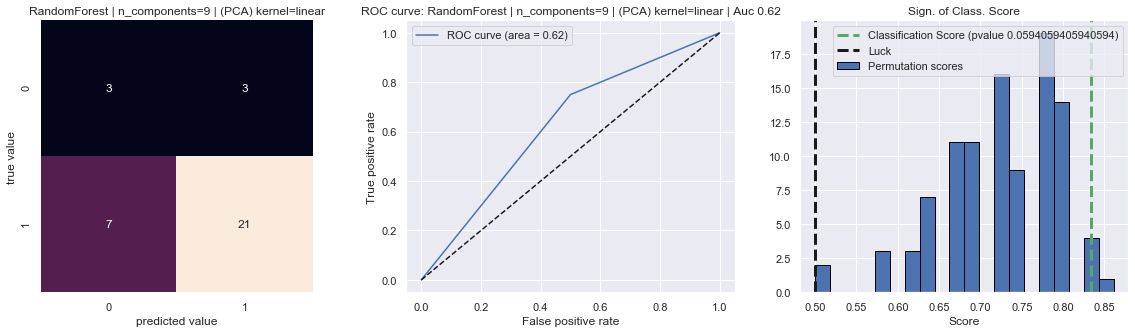

Kernel PCA: Poly | RandomForest


In [ ]:
plot_dest = os.path.join("figures", "n_comp_9_analysis", "grid_search")
X = rescaledX

df_gs, df_auc_gs = grid_search_all_by_n_components(
    estimators_list=estimators_list[6], \
    param_grids=param_grids[5],
    estimators_names=estimators_names[6], \
    X=X, y=y,
    n_components=9,
    random_state=0, show_plots=False, show_errors=False, verbose=1, plot_dest=plot_dest, debug_var=False)
df_9, df_9_auc = df_gs, df_auc_gs

Looking at the results obtained running *RandomForest Classifier* against our dataset splitted into training set and test set and adopting a different kernel trick applied to *kernel-Pca* unsupervised preprocessing method we can state generally speaking that all the such a *Statistical Learning technique* leads to a sequence of results...

- speaking about __Linear kernel Pca based RandomForest Classifier__, when adoping the default threshold of *.5* for classification purposes we have a model that reaches an accuracy of *%* at test time against an accuracy of *%* at train step, while the Auc score reaches a value of *%* with a Roc Curve that shows a behavior for which the model...

- observing __Polynomial kernel Pca based RandomForest Estimator__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *%* at test time against an accuracy of *%* at train step, while the Auc score reaches a value of *%*...

- review __Rbf kernel Pca based RandomForest Classifier__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *%* at test time against an accuracy of *%* at train step, while the Auc score reaches a value of *%*...

- looking at __Cosine kernel Pca based RandomForest Classifier__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *%* at test time against an accuracy of *%* at train step, while the Auc score reaches a value of *%*.

- finally, referring to __Sigmoid kernel Pca based RandomForest Model__, we can notice that such a model exploiting a default threshold of *.5* reaches an accuracy of *%* at test time against an accuracy of *%* at train step, while the Auc score reaches a value of *%*.

In [ ]:
create_widget_list_df([df_gs, df_auc_gs]) #print(df_gs); print(df_auc_gs)

Looking at the table dispalyed just above that shows the details about the selected values for hyper-parameters specified during grid search, in the different situations accordingly to the fixed kernel-trick for kernel Pca unsupervised method we can state that, referring to the first two columns of *Train and Test Accuracy*, we can recognize which trials lead to more overfit results such as for *Cosine, and Sigmoid Tricks* or less overfit solution such as in the case of *Linear, Polynomial, and Rbf Trick*. Speaking about the hyper-parameters, we can say what follows:

- looking at __n_estimators hyper-parameter__, which refers to the number of trees in the forest, ...

- reviewing __criterion parameter__, whcich represents the *function to measure the quality of a split* where supported criteria are *“gini”* for the Gini impurity and *“entropy”* for the information gain and this parameter is *tree-specific*...

- speaking about __bootstrap hyper-parameter__, we know that enabling it *bootstrap samples* are used when building trees, otherwise if disabled, the whole dataset is used to build each tree...

- looking at __min_samples_leaf hyper-param__, describes the minimum number of samples required to be at a leaf node...

- describing __max_features hyper-param__, a hyper-param as this referes to the number of features to consider when looking for the best split, and supported choicea are *“auto”, “sqrt”, “log2”*. If “auto”, then max_features=sqrt(n_features). If “sqrt”, then max_features=sqrt(n_features) (same as “auto”). If “log2”, then max_features=log2(n_features). And, finally If None, then max_features=n_features. We notice that the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

- looking at __max_depth hyper-param__, it reflects the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than *min_samples_split samples*...

- viewing __class_weight hyper-param__, referes to weights associated with classes and if not given, all classes are supposed to have weight one. The *“balanced”* mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). The *“balanced_subsample”* mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.


If we imagine to build up an *Ensemble Classifier* from the family of *Average Methods*, which state that the underlying principle leading their creation requires to build separate and single classifiers than averaging their prediction in regression context or adopting a majority vote strategy for the classification context, we can claim that amongst the purposed Knn classifier, for sure, we could employ the classifier foudn from the first three trials because of their performance metrics and also because Ensemble Methods such as Bagging Classifier, usually work fine exploiting an ensemble of independent and fine tuned classifier differently from Boosting Methods which instead are based on weak learners.

### Improvements and Conclusions <a class="anchor" id="Improvements-and-conclusions"></a>

## References section  <a class="anchor" id="references"></a>
### Main References
- Data Domain Information part:
    - (Deck) https://en.wikipedia.org/wiki/Deck_(bridge)
    - (Cantilever bridge) https://en.wikipedia.org/wiki/Cantilever_bridge
    - (Arch bridge) https://en.wikipedia.org/wiki/Deck_(bridge)
- Machine Learning part:
    - (Theory Book) https://jakevdp.github.io/PythonDataScienceHandbook/
    - (Feature Extraction: PCA) https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    - (Linear Model: Logistic Regression) https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    - (Neighbor-based Learning: Knn) https://scikit-learn.org/stable/modules/neighbors.html
    - (Stochastc Learning: SGD Classifier) https://scikit-learn.org/stable/modules/sgd.html#sgd
    - (Discriminative Model: SVM) https://scikit-learn.org/stable/modules/svm.html
    - (Non-Parametric Learning: Decsion Trees) https://scikit-learn.org/stable/modules/tree.html#tree
    - (Ensemble, Non-Parametric Learning: RandomForest) https://scikit-learn.org/stable/modules/ensemble.html#forest
- Metrics:
    - (F1-Accuracy-Precision-Recall) https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c
- Statistics:
    - (Correlation and dependence) https://en.wikipedia.org/wiki/Correlation_and_dependence
    - (KDE) https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
- Chart part:
    - (Seaborn Charts) https://acadgild.com/blog/data-visualization-using-matplotlib-and-seaborn
- Third Party Library:
    - (sklearn) https://scikit-learn.org/stable/index.html
    - (statsmodels) https://www.statsmodels.org/stable/index.html#
        
### Others References
- Plots:
    - (Python Plot) https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=255798340456&utm_targetid=aud-299261629574:dsa-473406587955&utm_loc_interest_ms=&utm_loc_physical_ms=1008025&gclid=Cj0KCQjw-_j1BRDkARIsAJcfmTFu4LAUDhRGK2D027PHiqIPSlxK3ud87Ek_lwOu8rt8A8YLrjFiHqsaAoLDEALw_wcB
- Markdown Math part:
    - (Math Symbols Latex) https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols
    - (Tutorial 1) https://share.cocalc.com/share/b4a30ed038ee41d868dad094193ac462ccd228e2/Homework%20/HW%201.2%20-%20Markdown%20and%20LaTeX%20Cheatsheet.ipynb?viewer=share
    - (Tutorial 2) https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html